# Building a Simple Agent Graph and Managing States

In this hands-on demo we will understand how states work in an agentic graph and also how to build a simple agentic graph just like the one shown below.

![](https://i.imgur.com/ILcvB2y.png)

## Install Dependencies

In [1]:
!pip install langchain==0.3.14
!pip install langgraph==0.2.66

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.9/326.9 kB 23.0 MB/s eta 0:00:00
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.3.0
    Uninstalling langsmith-0.3.0:
      Successfully uninstalled langsmith-0.3.0
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.15
    Uninstalling langchain-0.3.15:
      Successfully uninstalled langchain-0.3.15
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.3/145.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.1 MB/s eta 0:00:00


## State

First, define the [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of the graph.

The State schema serves as the input schema for all Nodes and Edges in the graph. This is basically the schema of the shared context or data messages passes throughout the graph across all the nodes and edges.

Let's use the `TypedDict` class from python's `typing` module as our schema, which provides type hints for the keys.

In [4]:
from typing_extensions import TypedDict

class State(TypedDict):
    messages: str

## Nodes

[Nodes](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes) are just python functions where we implement some custom logic, call some tools, LLMs etc.

The first positional argument is the state, as defined above. This gives the node the current state of the agent including the latest output messages, previous inputs etc.

Because the state is a `TypedDict` with schema as defined above, each node can access the key, `messages`, with `state['messages']`.

Each node returns a new value of the state key `messages`.
  
By default, the new value returned by each node [will overwrite](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior state value. (We will show shortly how to update new values to the state instead of overwriting)

In [5]:
def node_1(state: State) -> State:
    print("---Node 1---")
    state = state['messages']
    return {"messages": "Hello this is node 1"} # agent state gets written with a new updated value

## Edges

[Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges) connect the nodes.

Normal Edges are used if you want to *always* go from, for example, `node_1` to `node_2`.

## Build the Graph with Nodes and Edges and the State

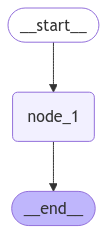

In [6]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## Test the Graph

In [7]:
graph.invoke({"messages": "Hi, how are you?."})

---Node 1---


{'messages': 'Hello this is node 1'}

## Graph with custom State Schema

You can define your own state schema with multiple fields and manipulate them inside the graph as shown below

In [8]:
from langgraph.graph import StateGraph, START, END

# Define the state structure
class State(TypedDict):
    data: str
    counter: int

# Initialize the StateGraph with the state schema
graph_builder = StateGraph(State)

# Add nodes and edges to your graph
# Define a node that processes the state
def process_state(state: State) -> State:
    print(f"Current data: {state['data']}, Counter: {state['counter']}")
    return {"data": state["data"].upper(), "counter": state["counter"] + 1}

# Add the node AND edges to the graph
graph_builder.add_node("process_state", process_state)
graph_builder.add_edge(START, "process_state")
graph_builder.add_edge("process_state", END)

# Compile the graph
graph = graph_builder.compile()

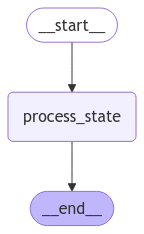

In [9]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
# Execute the graph with an initial state
initial_state = {"data": "hello world", "counter": 0}
result = graph.invoke(initial_state)

# Print the result
print("Final State:", result)

Current data: hello world, Counter: 0
Final State: {'data': 'HELLO WORLD', 'counter': 1}


## Graph with multiple processing nodes

So far we have built a graph with one node, lets now build one with three processing nodes and update (and overwrite) the overall state of the agent in each node

In [11]:
from typing_extensions import TypedDict

class State(TypedDict):
    messages: str

In [13]:
def node_1(state: State) -> State:
    print("---Node 1---")
    state = state['messages']
    return {"messages": "Hello this is node 1"}

def node_2(state):
    print("---Node 2---")
    state = state['messages']
    return {"messages": "Hello this is node 2"}

def final_node(state):
    print("---Node 3---")
    state = state['messages']
    return {"messages": "Hello this is the final node"}

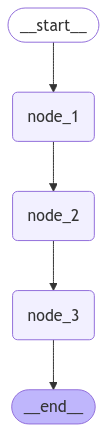

In [14]:
# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", final_node)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)


# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
graph.invoke({"messages": "Hi, how are you?."})

---Node 1---
---Node 2---
---Node 3---


{'messages': 'Hello this is the final node'}

The state gets overwritten each time in each node which is something which we do not want. We want the agent to be aware of what is happening in each node and store all the intermediate messages also.

Imagine a tool call happening only to get overwritten by something else!

This is where reducer functions can be used to update and append to the overall agent's state schema instead of overwriting

## Graph with multiple processing nodes

So far we have built a graph with one node, lets now build one with three processing nodes and update the overall state of the agent in each node without overwriting the overall state

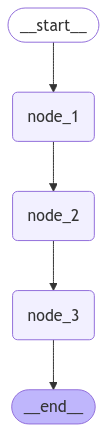

In [16]:
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages] # the reducer helps in appending to the state

def node_1(state: State) -> State:
    print("---Node 1---")
    state = state['messages']
    return {"messages": "Hello this is node 1"}

def node_2(state):
    print("---Node 2---")
    state = state['messages']
    return {"messages": "Hello this is node 2"}

def final_node(state):
    print("---Node 3---")
    state = state['messages']
    return {"messages": "Hello this is the final node"}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", final_node)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)


# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
response = graph.invoke({"messages": "Hi, how are you?."})
response

---Node 1---
---Node 2---
---Node 3---


{'messages': [HumanMessage(content='Hi, how are you?.', additional_kwargs={}, response_metadata={}, id='6082cdfc-5c58-4d86-8d67-de31d20f8887'),
  HumanMessage(content='Hello this is node 1', additional_kwargs={}, response_metadata={}, id='62f4b8c2-e624-49c5-93ff-e21dd309f609'),
  HumanMessage(content='Hello this is node 2', additional_kwargs={}, response_metadata={}, id='54711cd4-0304-4a64-a196-d9d793bf6abf'),
  HumanMessage(content='Hello this is the final node', additional_kwargs={}, response_metadata={}, id='cb950cf3-17e2-4ecd-9188-3870476421af')]}

In [18]:
response['messages'][-1]

HumanMessage(content='Hello this is the final node', additional_kwargs={}, response_metadata={}, id='cb950cf3-17e2-4ecd-9188-3870476421af')